<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-preamble-stuff" data-toc-modified-id="Random-preamble-stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random preamble stuff</a></span></li><li><span><a href="#C-SAPR-data-download" data-toc-modified-id="C-SAPR-data-download-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>C-SAPR data download</a></span></li><li><span><a href="#Process-C-SAPR-data-(phase)" data-toc-modified-id="Process-C-SAPR-data-(phase)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process C-SAPR data (phase)</a></span></li><li><span><a href="#Plot-figures,-including-NEXRAD-thing" data-toc-modified-id="Plot-figures,-including-NEXRAD-thing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot figures, including NEXRAD thing</a></span><ul class="toc-item"><li><span><a href="#Do-main-plots-(run-this-after-4.2)" data-toc-modified-id="Do-main-plots-(run-this-after-4.2)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Do main plots (run this after 4.2)</a></span></li><li><span><a href="#Download-NEXRAD-(run-this-before-4.1)" data-toc-modified-id="Download-NEXRAD-(run-this-before-4.1)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Download NEXRAD (run this before 4.1)</a></span></li></ul></li><li><span><a href="#Load-lightning-to-plot-with-RHIs-(incomplete)" data-toc-modified-id="Load-lightning-to-plot-with-RHIs-(incomplete)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load lightning to plot with RHIs (incomplete)</a></span></li></ul></div>

In [1]:
import glob
import os
from pathlib import Path
import act
import imageio as imageio
import matplotlib
import matplotlib.pyplot as plt
import pyart
from copy import deepcopy
import numpy as np
import cartopy.crs as ccrs
import shapely
import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
import pandas as pd
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,csu_dsd, csu_kdp, csu_misc)
import warnings
import matplotlib.cm as cm
import pyart.graph.cm as pcm
from lmatools.io.LMA_h5_file import LMAh5File
from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection
from dualpol import DualPolRetrieval # https://github.com/nasa/DualPol
from netCDF4 import Dataset
from pyproj import Geod


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Random preamble stuff

In [2]:
plt.rcParams['font.size'] = 14

In [3]:
import matplotlib.gridspec as gridspec

In [4]:
#define walkspace function
def walklevel(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
        yield root, dirs, files
        num_sep_this = root.count(os.path.sep)
        if num_sep + level <= num_sep_this:
            #print('hello!')
            del dirs[:]

## C-SAPR data download

In [33]:
act.discovery.download_data?

In [5]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

datastream = "houcsapr2cfrS2.a1"

#start_date = "2022-06-04T21:00:00"
#end_date   = "2022-06-04T21:20:00"
startdate = "2022-06-04"
enddate   = "2022-06-04"

In [34]:
#..Download a single time
#startdate = "2022-06-02T21:07:00"
#enddate = "2022-06-02T21:08:00"
startdate = "2022-06-04"
enddate = "2022-06-04"
june4_csapr_files = act.discovery.download_data(username,token,datastream,
                                                    startdate,enddate,time='210735')

[DOWNLOADING] houcsapr2cfrS2.a1.20220604.210735.nc


In [6]:
#..approximate metling level
melt_0604 = 4400/1000.

In [7]:
#..Downlaod CSAPR data or just load in pre-existing filenames
brand_new = False
if brand_new:
    june4_csapr_files = act.discovery.download_data(username,token,datastream,
                                                    startdate,enddate)
else:
    basepath = './houcsapr2cfrS2.a1/'
    numfiles = 0
    filepre = 'houcsapr'
    june4_csapr_files = []
    for root,dirs,files in walklevel(basepath,level=1):
        for file in files:
            if file.startswith(filepre): #change start with as string
                june4_csapr_files.append(file)
                numfiles += 1
june4_csapr_files = sorted(june4_csapr_files)
print(numfiles)

644


In [20]:
!mkdir quicklooks/rhi
!mkdir quicklooks/ppi
!mkdir quicklooks/vpt

In [25]:
#..Plot quicklooks of CSAPR
for file in june4_csapr_files:
    radar = pyart.io.read(file)
    print(radar.scan_type)
    if (radar.scan_type != 'other'):
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(111)
        display = pyart.graph.RadarDisplay(radar)
        display.plot("reflectivity", 0)
        fig.savefig(f"quicklooks/{radar.scan_type}/{Path(file).stem}.png", dpi=200)
        plt.close(fig)
        fig.clf()

ppi
ppi
rhi
ppi
rhi
rhi
rhi
rhi
ppi
ppi
rhi
rhi
rhi
ppi
rhi
ppi
rhi
rhi
rhi
rhi
rhi
rhi
rhi
rhi
rhi
other
ppi
rhi
other
other
rhi
other
other
rhi
ppi
rhi
rhi
ppi
other
ppi
rhi
rhi
other
ppi
other
rhi
ppi
other
rhi
ppi
other
other
rhi
rhi
other
rhi
rhi
rhi
other
rhi
ppi
rhi
other
ppi
rhi
rhi
rhi
ppi
ppi
rhi
rhi
rhi
ppi
ppi
rhi
ppi
ppi
rhi
rhi
rhi
rhi
rhi
rhi
ppi
ppi
rhi
rhi
rhi
ppi
rhi
rhi
rhi
rhi
rhi
rhi
rhi
rhi
other
rhi
rhi
ppi
rhi
ppi
other
rhi
other
rhi
rhi
rhi
other
rhi
rhi
ppi
rhi
rhi
rhi
ppi
rhi
ppi
ppi
rhi
rhi
ppi
rhi
other
other
rhi
ppi
other
rhi
rhi
rhi
ppi
other
rhi
other
rhi
ppi
rhi
other
ppi
rhi
rhi
other
rhi
rhi
other
ppi
rhi
ppi
rhi
ppi
rhi
ppi
rhi
rhi
ppi
other
rhi
rhi
rhi
rhi
rhi
rhi
rhi
other
ppi
ppi
rhi
ppi
other
rhi
rhi
other
rhi
other
rhi
rhi
ppi
other
rhi
rhi
ppi
other
rhi
rhi
rhi
other
rhi
ppi
ppi
ppi
rhi
rhi
other
rhi
other
rhi
other
rhi
rhi
rhi
other
ppi
rhi
rhi
ppi
other
rhi
rhi
other
rhi
other
rhi
ppi
other
other
ppi
rhi
rhi
rhi
ppi
rhi
ppi
other
ppi
ppi
othe

In [6]:
for i in range(numfiles):
    print(i,june4_csapr_files[i])

0 houcsapr2cfrS2.a1.20220604.125221.nc
1 houcsapr2cfrS2.a1.20220604.125451.nc
2 houcsapr2cfrS2.a1.20220604.130438.nc
3 houcsapr2cfrS2.a1.20220604.130522.nc
4 houcsapr2cfrS2.a1.20220604.130638.nc
5 houcsapr2cfrS2.a1.20220604.130739.nc
6 houcsapr2cfrS2.a1.20220604.130949.nc
7 houcsapr2cfrS2.a1.20220604.131018.nc
8 houcsapr2cfrS2.a1.20220604.131035.nc
9 houcsapr2cfrS2.a1.20220604.131103.nc
10 houcsapr2cfrS2.a1.20220604.131118.nc
11 houcsapr2cfrS2.a1.20220604.131315.nc
12 houcsapr2cfrS2.a1.20220604.131518.nc
13 houcsapr2cfrS2.a1.20220604.131619.nc
14 houcsapr2cfrS2.a1.20220604.200008.nc
15 houcsapr2cfrS2.a1.20220604.200037.nc
16 houcsapr2cfrS2.a1.20220604.200053.nc
17 houcsapr2cfrS2.a1.20220604.200109.nc
18 houcsapr2cfrS2.a1.20220604.200124.nc
19 houcsapr2cfrS2.a1.20220604.200138.nc
20 houcsapr2cfrS2.a1.20220604.200208.nc
21 houcsapr2cfrS2.a1.20220604.200225.nc
22 houcsapr2cfrS2.a1.20220604.200238.nc
23 houcsapr2cfrS2.a1.20220604.200254.nc
24 houcsapr2cfrS2.a1.20220604.200307.nc
25 houcsap

In [8]:
#..Hand selected "sets" of RHIs named by (arbitrary) index in my directory. Original
#..integers refer to listing if you follow above directions for download of CSAPR
offset = (1193-235)
csapr_idx1 = [1194-offset,1196-offset,1199-offset,1200-offset,1201-offset,1204-offset,
              1205-offset,1206-offset,1213-offset,1223-offset]
csapr_idx2 = [1209-offset,1210-offset,1214-offset,1215-offset,1216-offset,1219-offset]
csapr_idx3 = [393,]

In [9]:
print(csapr_idx1)

[236, 238, 241, 242, 243, 246, 247, 248, 255, 265]


In [10]:
print(june4_csapr_files[393])

houcsapr2cfrS2.a1.20220604.221847.nc


## Process C-SAPR data (phase)

In [12]:
#..Process all data specified by index for downloaded files
ii = 0
if brand_new:
    for idx in csapr_idx3:
        fname = june4_csapr_files[idx]
        radar = pyart.io.read(basepath+fname)
        retrieve = DualPolRetrieval(radar, gs=100.0, dz='reflectivity',
                              dr='differential_reflectivity',
                              #dr='RD',
                              dp='differential_phase',
                              rh='copol_correlation_coeff',
                              #fhc_T_factor=2, ice_flag=True,
                              #fhc_flag=False, ice_flag=False,dsd_flag=False,precip_flag=False,liquid_ice_flag=False,
                              fhc_flag=True, ice_flag=False,dsd_flag=True,precip_flag=True,liquid_ice_flag=False,
                              kdp_window=1.8, thresh_sdp=20.0, speckle=3,
                              #kdp_window=5, thresh_sdp=20.0, speckle=3,   #..prev
                              #kdp_window=5, thresh_sdp=20.0, speckle=10,
                              kdp_method='CSU',
                              rain_method='hidro',
                              qc_flag=True, verbose=False)
        print(testpath+fname[:-3] + '_proc.nc')
        pyart.io.write_cfradial(testpath+fname[:-3]+'_proc.nc', radar)
        ii += 1
else:
    pass

In [13]:
print(june4_csapr_files)

['houcsapr2cfrS2.a1.20220604.125221.nc', 'houcsapr2cfrS2.a1.20220604.125451.nc', 'houcsapr2cfrS2.a1.20220604.130438.nc', 'houcsapr2cfrS2.a1.20220604.130522.nc', 'houcsapr2cfrS2.a1.20220604.130638.nc', 'houcsapr2cfrS2.a1.20220604.130739.nc', 'houcsapr2cfrS2.a1.20220604.130949.nc', 'houcsapr2cfrS2.a1.20220604.131018.nc', 'houcsapr2cfrS2.a1.20220604.131035.nc', 'houcsapr2cfrS2.a1.20220604.131103.nc', 'houcsapr2cfrS2.a1.20220604.131118.nc', 'houcsapr2cfrS2.a1.20220604.131315.nc', 'houcsapr2cfrS2.a1.20220604.131518.nc', 'houcsapr2cfrS2.a1.20220604.131619.nc', 'houcsapr2cfrS2.a1.20220604.200008.nc', 'houcsapr2cfrS2.a1.20220604.200037.nc', 'houcsapr2cfrS2.a1.20220604.200053.nc', 'houcsapr2cfrS2.a1.20220604.200109.nc', 'houcsapr2cfrS2.a1.20220604.200124.nc', 'houcsapr2cfrS2.a1.20220604.200138.nc', 'houcsapr2cfrS2.a1.20220604.200208.nc', 'houcsapr2cfrS2.a1.20220604.200225.nc', 'houcsapr2cfrS2.a1.20220604.200238.nc', 'houcsapr2cfrS2.a1.20220604.200254.nc', 'houcsapr2cfrS2.a1.20220604.200307.nc',

In [15]:
testpath = './csapr_test/'
if False:       #...This is just a test with a single filename, can be ignored
    fname = june4_csapr_files[243]
    #nc = Dataset(basepath+fname[:-3]+'_proc.nc','r+')
    #nc = Dataset(testpath+fname[:-3]+'_proc.nc','r+')
    # nc = Dataset(testpath+fname,'r+')
    # nc.renameVariable(u'specific_differential_phase',u'old_kdp')
    # nc.close()
    #radar = pyart.io.read(testpath+fname[:-3]+'_proc.nc')
    radar = pyart.io.read(testpath+fname)

    #zc = deepcopy(radar.fields['reflectivity']['data'])    
    #radar.add_field_like('reflectivity', 'ZC', zc, replace_existing=True)
    # retrieve = DualPolRetrieval(radar, dz='reflectivity',
    #                             dr='differential_reflectivity',dp='differential_phase', 
    #                           rh='cross_correlation_ratio', 
    #                           fhc_T_factor=2, kdp_window=2,ice_flag=False, 
    #                           rain_method='hidro', qc_flag=True, gs=100.0, 
    #                           verbose=True, thresh_sdp=20.0, speckle=3)
    retrieve = DualPolRetrieval(radar, gs=100.0, dz='reflectivity',
                              dr='differential_reflectivity',
                              #dr='RD',
                              dp='differential_phase',
                              rh='copol_correlation_coeff',
                              #fhc_T_factor=2, ice_flag=True,
                              #fhc_flag=False, ice_flag=False,dsd_flag=False,precip_flag=False,liquid_ice_flag=False,
                              fhc_flag=True, ice_flag=False,dsd_flag=True,precip_flag=True,liquid_ice_flag=False,
                              kdp_window=1.8, thresh_sdp=20.0, speckle=3,
                              #kdp_window=5, thresh_sdp=20.0, speckle=3,   #..prev
                              #kdp_window=5, thresh_sdp=20.0, speckle=10,
                              kdp_method='CSU',
                              rain_method='hidro',
                              qc_flag=True, verbose=False)
    pyart.io.write_cfradial(testpath+fname[:-3] + '_proc.nc', radar)


## Plot figures, including NEXRAD thing

### Do main plots (run this after 4.2)

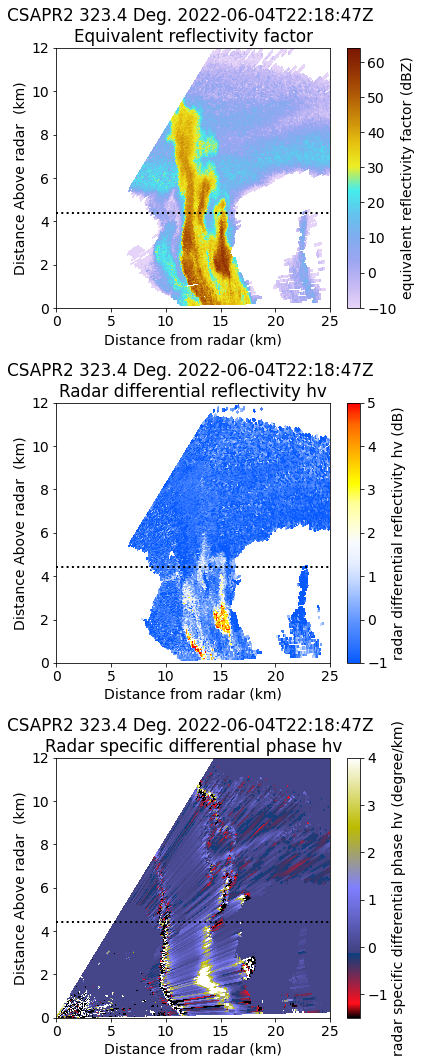

In [20]:
#...This is an example to test plotting
fname = june4_csapr_files[393]
radar = pyart.io.read(testpath+fname[:-3]+'_proc.nc')
#..
maxx = 25
maxz = 12
fig = plt.figure(figsize=(6, 15))
ax = fig.add_subplot(311)
display = pyart.graph.RadarDisplay(radar)
display.plot("reflectivity", 0,vmin=-10,vmax=64,cmap=pcm.LangRainbow12)
ax.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
ax.set_xlim(0,maxx)
ax.set_ylim(0,maxz)
#..
ax = fig.add_subplot(312)
display = pyart.graph.RadarDisplay(radar)
#display.plot("differential_reflectivity", 0)
#display.plot("differential_reflectivity",0,vmin=-1,vmax=5,
display.plot("attenuation_corrected_differential_reflectivity",0,vmin=-1,vmax=5,
             cmap=pcm.BuOrR14, mask_tuple=['reflectivity', -5.])
             #cmap=pcm.RefDiff)
             #cmap=pcm.RefDiff)
ax.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
ax.set_xlim(0,maxx)
ax.set_ylim(0,maxz)
#..
ax = fig.add_subplot(313)
display = pyart.graph.RadarDisplay(radar)
#display.plot("KDP_CSU", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
display.plot("specific_differential_phase", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
ax.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
ax.set_xlim(0,maxx)
ax.set_ylim(0,maxz)
fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig("example_defkdp.png", dpi=200)
#plt.close(fig)
#fig.clf()

In [184]:
#..This is the main plotting routine
#..
maxx = 25
maxz = 12
#for idx in [236,]:
for idx in csapr_idx3:
    fname = june4_csapr_files[idx]
    fig = plt.figure(figsize=(6, 18))
    gs = gridspec.GridSpec(4,1)
    #..
    radar = pyart.io.read(testpath+fname[:-3]+'_proc.nc')
    ax1 = fig.add_subplot(gs[0])
    display = pyart.graph.RadarDisplay(radar)
    display.plot("reflectivity", 0,vmin=-10,vmax=64,cmap=pcm.LangRainbow12,ax=ax1)
    ax1.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
    ax1.set_xlim(0,maxx)
    ax1.set_ylim(0,maxz)
    #..
    ax2 = fig.add_subplot(gs[1])
    display = pyart.graph.RadarDisplay(radar)
    #display.plot("differential_reflectivity", 0)
    #display.plot("differential_reflectivity",0,vmin=-1,vmax=5,
    display.plot("attenuation_corrected_differential_reflectivity",0,vmin=-1,vmax=5,
                 cmap=pcm.BuOrR14, mask_tuple=['reflectivity', -5.],ax=ax2)
                 #cmap=pcm.RefDiff)
                 #cmap=pcm.RefDiff)
    ax2.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
    ax2.set_xlim(0,maxx)
    ax2.set_ylim(0,maxz)
    #..
    ax3 = fig.add_subplot(gs[2])
    display = pyart.graph.RadarDisplay(radar)
    display.plot("KDP_CSU", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern,ax=ax3)
    #display.plot("specific_differential_phase", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
    ax3.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
    ax3.set_xlim(0,maxx)
    ax3.set_ylim(0,maxz)
    #..
    #..
    #...
    # Setting projection and ploting the second tilt
    projection = ccrs.LambertConformal(central_latitude=csapr_lat,
                                       central_longitude=csapr_lon)
    ax4  = fig.add_subplot(gs[3],projection=projection)
    numba = int(fname[-9:-3])
    thing = min(enumerate(khgx_times), key=lambda x: abs(x[1]-numba))
    if (thing[1]>numba):
        nexidx = thing[0]-1
    else:
        nexidx = thing[0]
    radar = pyart.io.read(testpath+fname[:-3]+'_proc.nc')
    az = radar.azimuth['data'][0]
    csapr_lat = radar.latitude['data'][0]
    csapr_lon = radar.longitude['data'][0]
    del radar
    radar = read_nexrad_key(keys[nexidx])
    display = pyart.graph.RadarMapDisplay(radar)

    lon_off = .4
    lat_off = .3
    display.plot_ppi_map('reflectivity', 2, ax=ax4, vmin=-4, vmax=64,
                         min_lon=csapr_lon-lon_off, max_lon=csapr_lon+lon_off, 
                         min_lat=csapr_lat-lat_off, max_lat=csapr_lat+lat_off,
                         lon_lines=np.arange(-158, -154, .2), resolution='10m',
                         lat_lines=np.arange(69, 72, .1), projection=projection,
                         fig=fig, lat_0=csapr_lat,
                         lon_0=csapr_lon)
    g = Geod(ellps='sphere')
    lon = csapr_lon
    lat = csapr_lat
    rng = 1000 *25
    lon2, lat2, _ = g.fwd(lon, lat, az, rng)
    plt.plot([csapr_lon, lon2], [csapr_lat, lat2], transform=ccrs.Geodetic(),c='r',lw=2)
    display.plot_point(csapr_lon, csapr_lat,c='r')
    #...
    #...
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    fig.savefig('./csapr_figs/rhi_'+fname[:-3]+'.png', dpi=200)
    plt.close(fig)
    fig.clf()

In [116]:
print(radar.fields)

{'attenuation_corrected_differential_reflectivity': {'_FillValue': -32767.0, 'long_name': 'Rainfall attenuation-corrected differential reflectivity', 'units': 'dB', 'coordinates': 'elevation azimuth range', 'standard_name': 'radar_differential_reflectivity_hv', 'unpacking_details': 'Can be unpacked as follows: multiply packed values by scale_factor field attribute, then add the add_offset field attribute.', 'data': masked_array(
  data=[[  7.9947205 ,  -1.9256239 ,   5.012208  , ...,  10.270708  ,
           1.2583165 ,  30.        ],
        [  5.3105354 ,   5.161753  ,  20.91131   , ...,  30.        ,
         -20.        ,  -0.13336992],
        [  0.54110956,   7.1684065 ,  23.850332  , ..., -20.        ,
          -0.13336992, -20.        ],
        ...,
        [  7.5926266 ,   5.104529  ,   4.34841   , ...,  -2.1674905 ,
           1.1194532 ,   0.05050993],
        [  8.233535  ,   5.0877433 ,   4.461332  , ..., -20.        ,
          -0.13336992,   1.6489654 ],
        [ 13.1

In [114]:
print(radar.azimuth['data'][0])

29.152222


### Download NEXRAD (run this before 4.1)

In [126]:
#del keys
keys = get_nexrad_keys('KHGX',start='20220604_210000',end='20220604_235000')
for key in keys:
    fname = os.path.split(str(key))[1][:-1]
    radar = read_nexrad_key(key)
    fnams = fname[0:4]+'_'+fname[-3:]+'_'+fname[4:8]+'_'+fname[8:12]+'_'+fname[13:19]+'.nc'
    pyart.io.write_cfradial(fnams,radar)

Found 35 keys.


In [127]:
print(int(fname[13:19]))

234533


In [128]:
#..Get times for each nexrad
khgx_times = []
for key in keys:
    fname = os.path.split(str(key))[1][:-1]
    khgx_times = np.r_[khgx_times,int(fname[13:19])]

210950
(2, 211028.0)


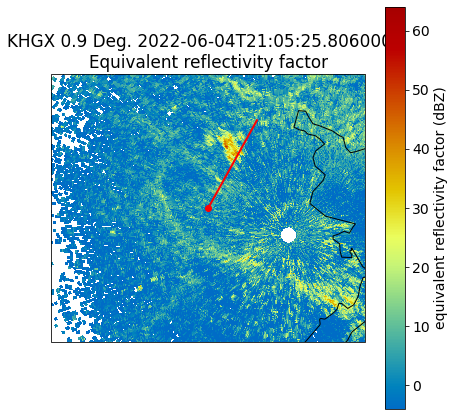

In [144]:
#..Test out plot of nexrad with line showing closest (after) CSAPR RHI direction
idx = 243
fname = june4_csapr_files[idx]
numba = int(fname[-9:-3])
print(numba)
thing = min(enumerate(khgx_times), key=lambda x: abs(x[1]-numba))
print(thing)
if (thing[1]>numba):
    nexidx = thing[0]-1
else:
    nexidx = thing[0]
radar = pyart.io.read(testpath+fname[:-3]+'_proc.nc')
az = radar.azimuth['data'][0]
csapr_lat = radar.latitude['data'][0]
csapr_lon = radar.longitude['data'][0]
del radar
radar = read_nexrad_key(keys[nexidx])
display = pyart.graph.RadarMapDisplay(radar)

# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=csapr_lat,
                                   central_longitude=csapr_lon)
fig = plt.figure(figsize=(6,6))
lon_off = .4
lat_off = .3
display.plot_ppi_map('reflectivity', 2, vmin=-4, vmax=64,
                     min_lon=csapr_lon-lon_off, max_lon=csapr_lon+lon_off, 
                     min_lat=csapr_lat-lat_off, max_lat=csapr_lat+lat_off,
                     lon_lines=np.arange(-158, -154, .2), resolution='10m',
                     lat_lines=np.arange(69, 72, .1), projection=projection,
                     fig=fig, lat_0=csapr_lat,
                     lon_0=csapr_lon)

g = Geod(ellps='sphere')
lon = csapr_lon
lat = csapr_lat
rng = 1000 *25

lon2, lat2, _ = g.fwd(lon, lat, az, rng)
plt.plot([csapr_lon, lon2], [csapr_lat, lat2], transform=ccrs.Geodetic(),c='r',lw=2)
display.plot_point(csapr_lon, csapr_lat,c='r')
fig.patch.set_facecolor('white')
fig.tight_layout()

In [131]:
print(radar.latitude['data'][0])

29.471900939941406


## Load lightning to plot with RHIs (incomplete)

In [187]:
import sys
sys.path.append("./LMAinterceptRHI/")
# Functions
from radarlma2local import geo_to_tps
from select_lma import one_flash
from plot_radar import plot_locs_lma_rhi, plot_RHI_EDR_panel,plot_EDR_dVR, plot_sources_interp
from ortho_proj import rot_mat_lma, closest_pt_radarloc, close_sources
from radar_processing import dealias_range_elev_derivatives, r_z_centers_edges_mesh
from interp_funcs import centers_to_edges_1d, coords_2d
from interp_funcs import oban, barnes, weighted_mean, weighted_std, interp_avg_std

In [189]:
# -- LIGHTNING
lma_base = './LYLOUT_220604_190000_18000_map500m.nc'
lma = LMAh5File(lma_base)
events, flashes = lma.data_for_table(lma.table_names[0])
flashes = pd.DataFrame(flashes)
events = pd.DataFrame(events)
events = events[events.alt < 16000.][events.stations > 5][events.chi2 < 5.]
potential = events

NoSuchNodeError: group ``/`` does not have a child named ``events``

In [ ]:
# -- RADAR
radar = pyart.io.read('houcsapr2cfrS2.a1.20220604.221847.nc')
# -- Creating EDR field parameter
gate_spacing = radar.range['meters_between_gates']/1000.
beamwidth = radar.instrument_parameters['radar_beam_width_h']['data'][0]
#pytda.calc_turb_rhi(radar, verbose = False, use_ntda=False, beamwidth=beamwidth, gate_spacing=gate_spacing)

# # -- Adding dealias velocity, dVRdr, dVRde fields to radar file
# import warnings
# warnings.simplefilter("ignore")
# radar = dealias_range_elev_derivatives(radar)

# arq_tur = './radar/turb_' + os.path.split(arq_ka)[1]
# # .nc export
# try:
#     os.remove(arq_tur)
# except OSError:
#     pass
# pyart.io.cfradial.write_cfradial(arq_tur, radar,format='NETCDF4')

# -- Get radar time
d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
radar_time = datetime.combine(d,t)
print(radar_time)


# -- Radar scan processing
#data = xr.open_dataset(arq_tur)
RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, 0)
# -- WITH THIS I'M ONLY TAKING 1 SWEEP IF I WANT MORE OR ALL I UNCOMMENT THE BELLOW LINES BUT IT TAKES A LONG TIME
# for sweep_idx in np.arange(1, len(data.sweep_start_ray_index)):
#     centers, edges = r_z_centers_edges_mesh(data, sweep_idx)
#     RZ_centers = np.append(RZ_centers, centers, axis = 0)
#     RZ_edges = np.append(RZ_edges, edges, axis = 0)
r_c = RZ_centers[:,:,0]
z_c = RZ_centers[:,:,1]
r_e = RZ_edges[:,:,0]
z_e = RZ_edges[:,:,1]

# -- To filter VHF sources out of the radar scan domain
# --- Create the polygon: all ranges, lowest and highest elevation
# --- ~ 23 km (IDX 221), 23.5 km (IDX 165)range all elevations
# RZ_edges[:, - 165]
from shapely.geometry import Polygon, Point, MultiPoint
scan_poly = Polygon(np.append(np.append(RZ_edges[-1, :-221],RZ_edges[0, :-221], axis = 0), RZ_edges[:, - 221], axis = 0))

# -- FLASH
# --- Select the flash #k
flash = one_flash(potential, flashes_id[k])
flash = flash.sort_values(by=['time'])

# --- Orthogonal projection/ Matrix Rotation of the LF sources
Xlma,Ylma,Zlma = geo_to_tps(flash, radar)
XYZlma = np.column_stack((Xlma, Ylma, Zlma))
lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)

# -- Initialize coordinate systems
ctrlat, ctrlon, ctralt = data.latitude.values, data.longitude.values, data.altitude.values
geo = GeographicSystem()
tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

# -- First source location in the cross section
alt_lma_init = flashes.init_alt[flashes.flash_id == flash.flash_id.values[0]].values[0]
lat_lma_init = flashes.init_lat[flashes.flash_id == flash.flash_id.values[0]].values[0]
lon_lma_init = flashes.init_lon[flashes.flash_id == flash.flash_id.values[0]].values[0]
m = rot_mat_lma(radar, np.column_stack(tps.toLocal(np.vstack(geo.toECEF(lon_lma_init, lat_lma_init, alt_lma_init)))), -1)[0]
X1, Y1, Z1 = m[0], m[1], m[2]

# 1st STEP
# -- Find and store sources within a certain distance
ds = 100 # threshold
r_cls, z_cls, y_min = close_sources(r_c, z_c, lma_file_ortho, ds)
# -- Selected LMA sources inside the radar scan
lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
R_cls = [] 
Z_cls = []
Y_min = []
for i in np.arange(len(r_cls)):
    if scan_poly.contains(lma_shp[i]) == True:
        R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
        Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
        Y_min.append(y_min[i])
R_cls = np.asarray(R_cls)
Z_cls = np.asarray(Z_cls)
Y_min = np.asarray(Y_min)